In [2]:
import numpy as np
import torch

In [ ]:
torch.__version__

'1.8.0+cu101'

In [ ]:
torch.cuda.is_available()

False

1. Tensors (torch.Tensor, Tensor Attributes)

In [ ]:
#from python list or sequence
a = [[1_000, 0], [3, 4]]
#dtype int8, unsigned int8, int16, int32, int64, float16, float32, float64, boolean
x = torch.tensor(a, dtype=torch.bool, device='cpu')
x.dtype, x.device, x.stride() #reference to tensor.Storage

(torch.bool, device(type='cpu'), (2, 1))

In [ ]:
# 9 cpu constructors with specific dtype [torch.FloatTensor ...]
# 9 gpu constructors with specific dtype [torch.cuda.FloatTensor ...]

torch.float32

In [ ]:
# from array_like data
a = np.array([[1_000, 0], [3, 4]])
q = torch.as_tensor(a) #avoid copy
q[0, 0] = -1
a[0, 0], q.device
#on gpu this trick isn't work

(-1, device(type='cpu'))

In [ ]:
#from numpy (see bridge section)

In [ ]:
#from another tensor
data = torch.tensor([[1, 2], [3, 4]])
x_ones = torch.ones_like(data)

x_rand = torch.rand_like(data, dtype=torch.float16)

x_ones, x_ones.dtype, x_rand, x_rand.dtype

(tensor([[1, 1],
         [1, 1]]), torch.int64, tensor([[0.7793, 0.8838],
         [0.1787, 0.9209]], dtype=torch.float16), torch.float16)

In [ ]:
#numpy axis is equal to torch dim
a = np.array([[[1, 2, 3], 
               [3, 4, 0]],
                        [[1, 2, 3], 
                        [3, 4, 0]]])
a.shape, a.sum(axis=0), a.sum(axis=1), a.sum(axis=2)

((2, 2, 3), array([[2, 4, 6],
        [6, 8, 0]]), array([[4, 6, 3],
        [4, 6, 3]]), array([[6, 7],
        [6, 7]]))

In [ ]:
b = torch.tensor(a)
b.sum(dim=0), b.sum(dim=1), b.sum(dim=2)

(tensor([[2, 4, 6],
         [6, 8, 0]]), tensor([[4, 6, 3],
         [4, 6, 3]]), tensor([[6, 7],
         [6, 7]]))

In [ ]:
# tensor operations
# that have a _ suffix are in-place
#x.copy_(y)
#x.t_()
tensor = torch.ones((3, 3))
tensor.add_(5)
tensor

tensor([[6., 6., 6.],
        [6., 6., 6.],
        [6., 6., 6.]])

In [ ]:
#numpy pytorch bridge
#Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.
  # torch -> numpy
t = torch.ones(5)
n = t.numpy()
t, n

(tensor([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.], dtype=float32))

In [ ]:
t.add_(5)
t, n

(tensor([6., 6., 6., 6., 6.]), array([6., 6., 6., 6., 6.], dtype=float32))

In [ ]:
  #numpy -> torch
n = np.ones(3)
t = torch.from_numpy(n)
n, t

(array([1., 1., 1.]), tensor([1., 1., 1.], dtype=torch.float64))

In [ ]:
np.add(n, 1, out=n)
n, t

(array([2., 2., 2.]), tensor([2., 2., 2.], dtype=torch.float64))

2. torch.Autograd

In [ ]:
#torch autograd
  #out = t^2
t = torch.tensor([1, 2, 3], dtype=torch.float32, requires_grad=True)
out = t.pow(2)
out, t.shape

(tensor([1., 4., 9.], grad_fn=<PowBackward0>), torch.Size([3]))

In [ ]:
  #When we call .backward() on OUT, autograd calculates these gradients and stores them in the respective tensor's .grad attribute.
  #We need to explicitly pass a gradient argument in OUT.backward() because it is a vector. gradient is a tensor of the same shape as OUT, and it represents the gradient of the OUT itself
out.backward(gradient=torch.tensor([1, 1, 1]))

In [ ]:
t.grad

tensor([2., 4., 6.])

In [ ]:
  #Equivalently, we can aggregate Q into a scalar and call backward implicitly [grad can be implicitly created only for scalar outputs]
t = torch.tensor([1, 2, 3], dtype=torch.float32, requires_grad=True)
out2 = t.pow(2).sum()
out2

tensor(14., grad_fn=<SumBackward0>)

In [ ]:
out2.backward()
t.grad

tensor([2., 4., 6.])

In [ ]:
out2.grad_fn

In [ ]:
  # Pytorch support differentiation of a scalar functions (self derivative is 1), os if we want too start backward from a non-scalar value, we provide torch.tensor in backward(gradient=...)

In [18]:
  #Example 2
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
Q = 3*a**3 - b**2

In [19]:
Q.backward(gradient=torch.tensor([1., 1.]))

In [20]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


In [ ]:
  #Generally speaking, torch.autograd is an engine for computing vector-Jacobian product. That is, given any vector v, compute the product J.T * v (see perfect example in doc)

3. Computational Graph

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting tensors) in a **directed acyclic graph DAG** consisting of a autograd.Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracking this graph from roots to leaves, you can automatically compute the gradients using the chain rule.


In a forward pass, autograd does twoo things simultaneously:
  - run the requested operation to compute a resulting tensor
  - maintain the operation's gradient function in the DAG

The backward pass kicks off when .backward is called on the DAG root. autograd then:
  - computes the gradients from each .grad_fn
  - accumulates them in the respective tensor's .grad attribute
  - using the chain rule, propagates all the way to the leaf tensors

**DAGs are dynamic in PyTorch and, after .backward() call, autograd starts populate a new graph.**

In [ ]:
  #Exclusion from the DAG - requires_grad = False (frozen parameters - we dont need their parameters)
  #is important for funetuning a pretrained network

In [ ]:
from torch import nn, optim
import torchvision

model = torchvision.models.resnet18(pretrained=True)

#freeze all the parameters in the network
for param in model.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


let's say we want to finetune the model on a new dataset with 10 label. In resnet, the classifier is the last linear layer model.fc. We can simply replace it with a new linear layer (unfrose by default)

In [ ]:
model.fc = nn.Linear(512, 10)

In [ ]:
#optimize only the classifier
optimizer = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)
#same functionality is available as a context manager in torch.no_grad()

4. Neural network

A typical trainig procedure for a nn is as follows:
  - define the neural network that has some learnable parameters (as weights)
  - iterate over a dataset or inputs
  - process input through the network
  - compute the loss
  - propagate gradients back into hte network's parameters 
  - update the weights  of the network, typically using a smiple update rule: weight-=lr*gradients

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16 * 6 * 6, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    #print(num_features) == 576 in our case
    return num_features

net = Net()
print(net)    

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
##### view #####
tensor = torch.tensor([[1, 2], [3, 4]])
b = tensor.view((-1, 4)) # -1 mean inferred (предполагаемый == досчитай сам это очевидно)

In [ ]:
b.storage().data_ptr() == tensor.storage().data_ptr()

True

In [ ]:
b, tensor

(tensor([[1, 2, 3, 4]]), tensor([[1, 2],
         [3, 4]]))

In [ ]:
################

In [ ]:
#learnable parameters
params = list(net.parameters())
len(params), params[0].size()

(10, torch.Size([6, 1, 3, 3]))

In [ ]:
params[0].__class__

torch.nn.parameter.Parameter

In [6]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0220, -0.0858,  0.0628,  0.1416,  0.0347, -0.0692, -0.0015, -0.0239,
         -0.0878, -0.0229]], grad_fn=<AddmmBackward>)


In [ ]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [ ]:
# Loss function

In [7]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

print(output.shape, target.shape)
loss = criterion(output, target)
print(loss)

torch.Size([1, 10]) torch.Size([1, 10])
tensor(1.0460, grad_fn=<MseLossBackward>)


input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> view -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss

In [13]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [9]:
def get_next_f(grad_fn):
  try:
    print(grad_fn.next_functions[0][0])
  except:
    return
  get_next_f(grad_fn.next_functions[0][0])

In [11]:
print(loss.grad_fn)
get_next_f(loss.grad_fn)

In [14]:
# backprop error
# 1 - clear gradients
net.zero_grad()
# 2 backpropagate
loss.backward()

In [16]:
#update the weights of the net
# 1 forwardpass
learning_rate = 0.01

for f in net.parameters():
  f.data.sub_(f.grad.data * learning_rate)
  #grad.data - A PyTorch Tensor represents a node in a computational graph. 
  #If x is a Tensor that has x.requires_grad=True then x.grad is another Tensor holding the gradient of x with respect to some scalar value.

# 2 torch.optim

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()

output = net(input)

loss = criterion(output, target)

loss.backward()

optimizer.step() # does the update

5. Training a classifier

5.1 load and normalizing the CIFAR10 training and test datasets using torchvision

5.2 define a CNN

5.3 define a loss function

5.4 train the network on the training data

5.5 test the network on the test data

In [27]:
#5.1

import torch
import torchvision
import torchvision.transforms as transforms

In [28]:
  #the output of torchvision dataset are PLIImage image of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
  # Normalize - mean and std for n channels
  #Eq = out = (inp - mean) / std

In [29]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


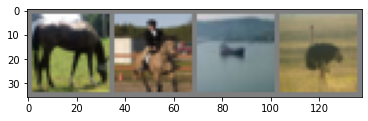

    horse     horse      ship      bird


In [35]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img/2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%9s' % classes[labels[j]] for j in range(trainloader.batch_size)))

In [36]:
#5.2

In [37]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

In [39]:
#5.3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [41]:
#5.4
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
print('Finished!')

[1,  2000] loss: 2.238
[1,  4000] loss: 1.901
[1,  6000] loss: 1.705
[1,  8000] loss: 1.585
[1, 10000] loss: 1.532
[1, 12000] loss: 1.473
[2,  2000] loss: 1.407
[2,  4000] loss: 1.383
[2,  6000] loss: 1.332
[2,  8000] loss: 1.332
[2, 10000] loss: 1.305
[2, 12000] loss: 1.275
Finished!


In [42]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

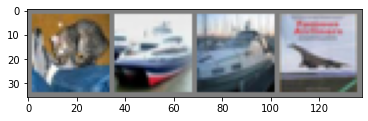

      cat      ship      ship     plane


In [43]:
#5.5 test

dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%9s' % classes[labels[j]] for j in range(testloader.batch_size)))

In [44]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

In [45]:
_, predicted = torch.max(outputs, dim=1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [47]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 75 %
Accuracy of  bird : 44 %
Accuracy of   cat : 29 %
Accuracy of  deer : 33 %
Accuracy of   dog : 46 %
Accuracy of  frog : 71 %
Accuracy of horse : 64 %
Accuracy of  ship : 70 %
Accuracy of truck : 49 %


In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)